In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('../data/time_series_19-covid-Confirmed.csv')

Using TensorFlow backend.


In [84]:
s.diff().fillna(0)

,Cumulative_Number_Of_Case(s),Number_Of_Deaths,Number_Recovered
Date,,,
2003-03-17,0.0,0.0,0.0
2003-03-18,52.0,0.0,0.0
2003-03-19,45.0,5.0,0.0
2003-03-20,42.0,1.0,0.0
2003-03-21,44.0,0.0,0.0
...,...,...,...
2003-07-07,0.0,0.0,0.0
2003-07-08,-3.0,0.0,2.0
2003-07-09,0.0,0.0,10.0


Epoch 1/180
13/13 [==============================] - 1s 47ms/step - loss: 0.0156
Epoch 2/180
13/13 [==============================] - 0s 26ms/step - loss: 0.0108
Epoch 3/180
13/13 [==============================] - 0s 27ms/step - loss: 0.0108
Epoch 4/180
13/13 [==============================] - 0s 26ms/step - loss: 0.0089
Epoch 5/180
13/13 [==============================] - 0s 23ms/step - loss: 0.0091
Epoch 6/180
13/13 [==============================] - 0s 28ms/step - loss: 0.0093
Epoch 7/180
13/13 [==============================] - 0s 27ms/step - loss: 0.0083
Epoch 8/180
13/13 [==============================] - 0s 26ms/step - loss: 0.0082
Epoch 9/180
13/13 [==============================] - 0s 27ms/step - loss: 0.0089
Epoch 10/180
13/13 [==============================] - 0s 27ms/step - loss: 0.0079
Epoch 11/180
13/13 [==============================] - 0s 27ms/step - loss: 0.0080
Epoch 12/180
13/13 [==============================] - 0s 26ms/step - loss: 0.0076
Epoch 13/180
13/13 [=====

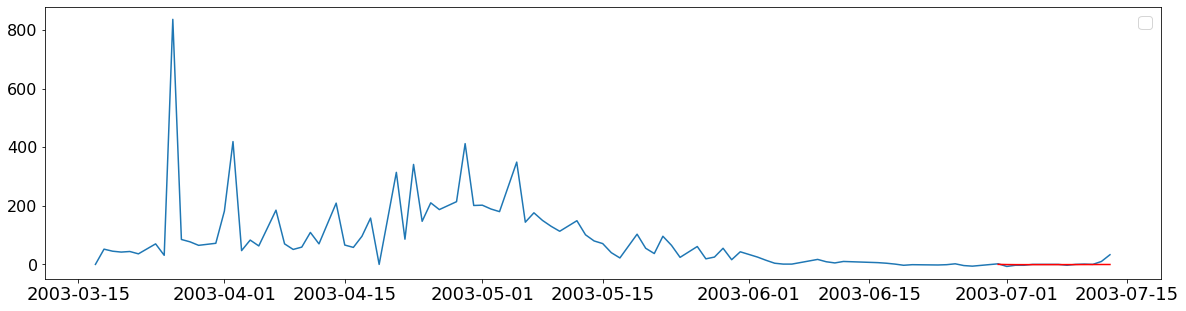

In [85]:
sars = pd.read_csv('../data/sars_chn_agg.csv')
sars.Date = pd.to_datetime(sars.Date)
s = sars.groupby('Date').agg('sum')
s.index = pd.to_datetime(s.index)
# df = s[['Cumulative_Number_Of_Case(s)']].rename(columns={'Cumulative_Number_Of_Case(s)':'Confirmed'})
df = s.diff().fillna(0)[['Cumulative_Number_Of_Case(s)']].rename(columns={'Cumulative_Number_Of_Case(s)':'Confirmed'})
df.reset_index(inplace=True)
df = df.append({'Date':'2003-07-12 00:00:00','Confirmed':np.nan},ignore_index=True)
df = df.append({'Date':'2003-07-13 00:00:00','Confirmed':33},ignore_index=True)
df.set_index('Date',inplace=True)
df.index = pd.to_datetime(df.index)
df = df.interpolate(method='polynomial', order=2)
train, test = df[:-12], df[-12:]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=180)

pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)


df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict], axis=1)

plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Confirmed'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

rmse:  [10.34455607]
Epoch 1/180
15/15 [==============================] - 0s 20ms/step - loss: 0.0026
Epoch 2/180
15/15 [==============================] - 0s 27ms/step - loss: 0.0021
Epoch 3/180
15/15 [==============================] - 0s 25ms/step - loss: 0.0027
Epoch 4/180
15/15 [==============================] - 0s 25ms/step - loss: 0.0026
Epoch 5/180
15/15 [==============================] - 0s 30ms/step - loss: 0.0035
Epoch 6/180
15/15 [==============================] - 0s 19ms/step - loss: 0.0036
Epoch 7/180
15/15 [==============================] - 0s 25ms/step - loss: 0.0032
Epoch 8/180
15/15 [==============================] - 0s 26ms/step - loss: 0.0031
Epoch 9/180
15/15 [==============================] - 0s 27ms/step - loss: 0.0027
Epoch 10/180
15/15 [==============================] - 0s 26ms/step - loss: 0.0031
Epoch 11/180
15/15 [==============================] - 0s 29ms/step - loss: 0.0025
Epoch 12/180
15/15 [==============================] - 0s 24ms/step - loss: 0.0023
Epoc

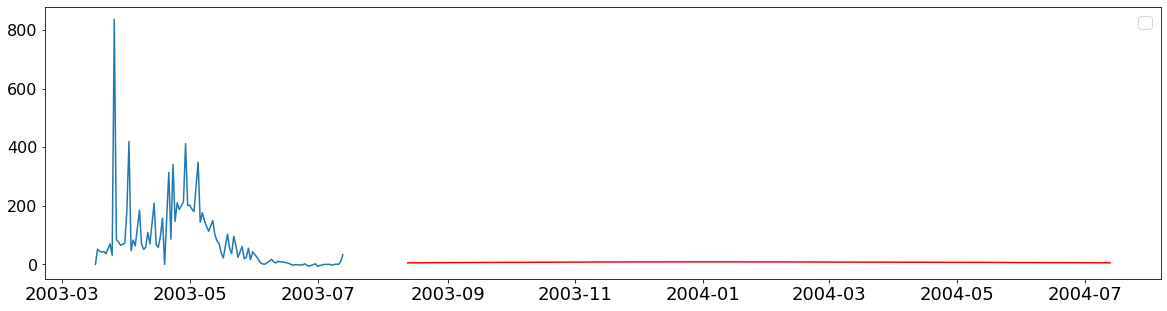

In [86]:
#sars cont.
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

train = df
scaler.fit(train)
train = scaler.transform(train)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model.fit_generator(generator,epochs=180)
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)


from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['Confirmed'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [5]:
#covid19

confirmed = df.iloc[:,4:].sum()
c19a = pd.DataFrame(confirmed).rename(columns={0:'Confirmed'})
c19a.index = pd.to_datetime(c19a.index)
df = c19a


train, test = df[:-12], df[-12:]

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)


n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)


model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator,epochs=90)


pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)





    
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict], axis=1)

plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Confirmed'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()



pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)



In [ ]:
#covid19 cont.
train = df
scaler.fit(train)
train = scaler.transform(train)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model.fit_generator(generator,epochs=90)
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

In [34]:
# train, test = df[:-12], df[-12:]

In [35]:
# scaler = MinMaxScaler()
# scaler.fit(train)
# train = scaler.transform(train)
# test = scaler.transform(test)

In [36]:
# n_input = 12
# n_features = 1
# generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [39]:
# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dropout(0.1))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

In [76]:
# model.fit_generator(generator,epochs=90)

In [41]:
# pred_list = []

# batch = train[-n_input:].reshape((1, n_input, n_features))

# for i in range(n_input):   
#     pred_list.append(model.predict(batch)[0]) 
#     batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [42]:
# df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
#                           index=df[-n_input:].index, columns=['Prediction'])

# df_test = pd.concat([df,df_predict], axis=1)

No handles with labels found to put in legend.


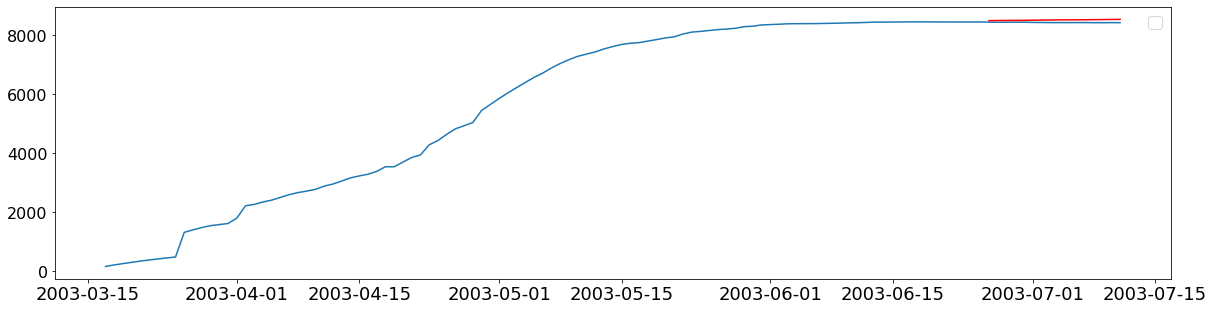

In [43]:
# plt.figure(figsize=(20, 5))
# plt.plot(df_test.index, df_test['Confirmed'])
# plt.plot(df_test.index, df_test['Prediction'], color='r')
# plt.legend(loc='best', fontsize='xx-large')
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=16)
# plt.show()

In [44]:
# pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
# print("rmse: ", pred_actual_rmse)

rmse:  [88.64677299]


In [45]:
# train = df

In [46]:
# scaler.fit(train)
# train = scaler.transform(train)

In [47]:
# n_input = 12
# n_features = 1
# generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [78]:
# model.fit_generator(generator,epochs=90)

In [49]:
# pred_list = []

# batch = train[-n_input:].reshape((1, n_input, n_features))

# for i in range(n_input):   
#     pred_list.append(model.predict(batch)[0]) 
#     batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [50]:
# from pandas.tseries.offsets import DateOffset
# add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
# future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [51]:
# df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
#                           index=future_dates[-n_input:].index, columns=['Prediction'])

# df_proj = pd.concat([df,df_predict], axis=1)

No handles with labels found to put in legend.


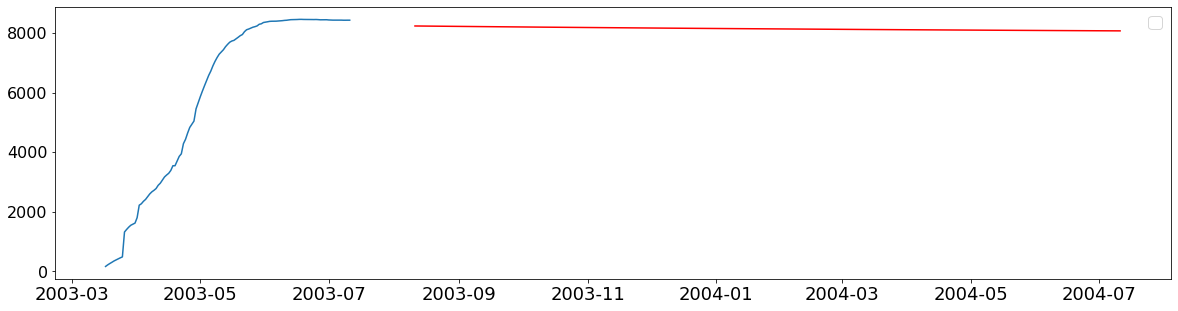

In [52]:
# plt.figure(figsize=(20, 5))
# plt.plot(df_proj.index, df_proj['Confirmed'])
# plt.plot(df_proj.index, df_proj['Prediction'], color='r')
# plt.legend(loc='best', fontsize='xx-large')
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=16)
# plt.show()